# Exploring the Cherenkov process of high energy muons in H2O

The Frank-Tamm formula

$$ {\frac {d^{2}E}{dx\,d\omega }}={\frac {q^{2}}{4\pi }}\mu (\omega )\omega {\left(1-{\frac {c^{2}}{v^{2}n^{2}(\omega )}}\right)}$$

provided that $\beta ={\frac  {v}{c}}>{\frac  {1}{n(\omega )}}$. Here ${\mu (\omega )}$ and $n(\omega )$ are the frequency-dependent permeability and index of refraction of the medium respectively, $q$ is the electric charge of the particle, $v$ is the speed of the particle, and $c$ is the speed of light in vacuum.


Energy per unit length due to Cherenkov radiation is:

$$ {\frac  {dE}{dx}}={\frac  {q^{2}}{4\pi }}\int _{{v>{\frac  {c}{n(\omega )}}}}\mu (\omega )\omega {\left(1-{\frac  {c^{2}}{v^{2}n^{2}(\omega )}}\right)}d\omega $$


Now say we have a ~100 GeV muon going through an Outer Detector/Shield at SNOLAB (~13 m of water). Can we approximate the losses due to the Cherenkov effect negligable? yeah, we expect something like a few hundred MeV losses at most.

Okay, now let's simplify things by ignoring ionization, brehmstralung, and scattering (this is super high energy and will mostly go in a straight line). What will the visible portion of the Cherenkov photon distribution look like on the detector walls?

In [1]:
import numpy as np
#from numpy.random import choice
import matplotlib.pyplot as plt
from numba import jit, njit, float64, int64, prange, cuda, guvectorize

Text(0, 0.5, 'Real Index of Refraction')

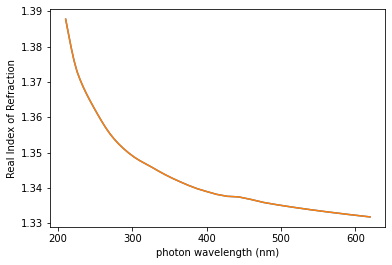

In [2]:
from scipy.interpolate import PchipInterpolator
#%matplotlib notebook
#In eV
energies = np.array([0.602, 0.689, 1.03,  1.926, 2.583, 2.845, 2.857, 3.124,3.457, 3.643, 3.812, 4.086, 4.511, 4.953, 5.474, 6.262, 7.000, 8.300, 10.00, 12.60])
#Refractive index of water from Segelstein, David J. The complex refractive index of water. Diss. University of Missouri--Kansas City, 1981.
n = np.array([1.303, 1.3120,   1.3239,   1.3313, 1.3358, 1.3376, 1.3376, 1.3392, 1.3423, 1.3442, 1.3460, 1.3486, 1.3540, 1.3619, 1.3723, 1.3960, 1.3960, 1.3960,1.3960, 1.3960])

energies_dens= np.arange(2.0, 6.0, 0.1)
cs_energies_dens = PchipInterpolator(energies, n)

refractive_dens= cs_energies_dens(energies_dens)

plt.plot(1239.8/energies_dens, refractive_dens)

wavelengths = 1239.8/energies
wavelengths_dens = 1239.8/energies_dens

freq = 3e17/wavelengths
freq_dens = 3e17/wavelengths_dens


#Only take the ~near visible range (where photomultiplier tubes are sensitive). 
#This is the tail of the Cherenkov emission spectrum.
cut=-4
freq = freq[2:cut]
wavelengths=wavelengths[2:cut]
energies=energies[2:cut]
n=n[2:cut]

plt.plot(wavelengths_dens, refractive_dens)
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Real Index of Refraction')


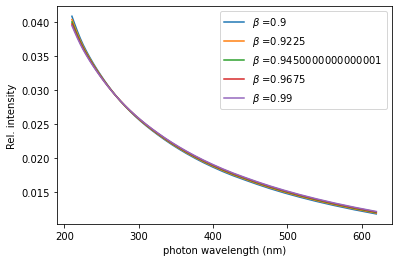

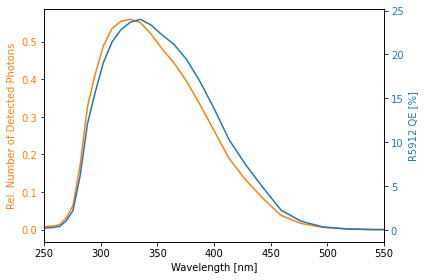

18
[619.9        590.38095238 563.54545455 539.04347826 516.58333333
 495.92       476.84615385 459.18518519 442.78571429 427.51724138
 413.26666667 399.93548387 387.4375     375.6969697  364.64705882
 354.22857143 344.38888889 335.08108108 326.26315789 317.8974359
 309.95       302.3902439  295.19047619 288.3255814  281.77272727
 275.51111111 269.52173913 263.78723404 258.29166667 253.02040816
 247.96       243.09803922 238.42307692 233.9245283  229.59259259
 225.41818182 221.39285714 217.50877193 213.75862069 210.13559322]
[ 0.00581905  0.0022008   0.00071125  0.00093898  0.00232554  0.00596523
  0.01642426  0.03795486  0.08463499  0.13386047  0.18983273  0.26445038
  0.33388331  0.39545823  0.44395194  0.48082281  0.52087215  0.55116256
  0.55959413  0.5546297   0.53474967  0.48940036  0.4140822   0.32747957
  0.17016375  0.06374432  0.0312251   0.01318176  0.00981053  0.00869485
  0.00665201  0.00425653  0.00230444  0.0006611  -0.00069377 -0.0017844
 -0.00264083 -0.00329525 -0.0037

In [3]:
#I think mu(w) is constant in this range... So we can ignore the normalization then normalize later
b = np.linspace(0.9, 0.99, 5)



#for beta in b:
    #E_loss = 1.0/(4*np.pi) * freq_dens*(1.0 - 1.0/(beta**2.0 * refractive_dens**2.0))
    #plt.plot(freq_dens,E_loss/np.abs(E_loss.sum()), '*', label=r'$\beta$ ='+str(beta))
    
#plt.xlabel('photon frequency')
#plt.ylabel('Rel. intensity')
#plt.legend()
#plt.show()

for beta in b:
    E_loss = 1.0/(4*np.pi) * freq_dens*(1.0 - 1.0/(beta**2.0 * refractive_dens**2.0))
    plt.plot(wavelengths_dens,E_loss/np.abs(E_loss.sum()), '-',label=r'$\beta$ ='+str(beta) )
    
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Rel. intensity')
plt.legend()
plt.show()


fname = "R5912_data.txt"
QE_data = np.loadtxt(fname, dtype=float, delimiter=",", converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)


cs = PchipInterpolator(QE_data[:,0], QE_data[:,1])
#plt.plot(1239.8/QE_data[:,0], QE_data[:,1], label="QE Data")
#plt.plot(1239.8/energies_dens, cs(energies_dens), label="Interpolated QE Data")
#plt.plot(1239.8/energies_dens, cs(energies_dens)*E_loss/np.abs(E_loss.sum()), label="Detected Photons")
#plt.legend()
#plt.xlabel("Photon Energy [eV]")
#plt.ylabel("R5912 PMT QE [%]")
#plt.show()

fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Rel. Number of Detected Photons', color=color)
ax1.plot(1239.8/energies_dens, cs(energies_dens)*E_loss/np.abs(E_loss.sum()), label="Detected Photons", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R5912 QE [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(1239.8/energies_dens, cs(energies_dens), label="Interpolated QE Data", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.xlim(250, 550)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print(np.argmax(cs(energies_dens)*E_loss/np.abs(E_loss.sum())))
print(1239.8/energies_dens)
print(cs(energies_dens)*E_loss/np.abs(E_loss.sum()))
print(1239.8/energies_dens[12], 1239.8/energies_dens[18], 1239.8/energies_dens[24])



In [5]:
#Checking to see if our generated Cherenkov spectrum looks right.
freqSample = []
freqDensSpan=np.linspace(freq[0], freq[-1], 1000)
freqDens = np.interp(freqDensSpan, freq, E_loss)
freqDens = freqDens/np.abs(freqDens.sum()) #normalize

#for i in range(10000):
#    freqSample.append(np.random.choice(np.linspace(freqDensSpan[0],freqDensSpan[-1], len(freqDens)),p=freqDens))
    
#plt.hist(freqSample)

ValueError: fp and xp are not of the same length.

Let's take the muon angular distribution from the Mei & Hime paper in 2006 [1]. This characterizes the muon flux. Let's convert this to a flux through a horizontal disc at a depth of SNOLAB. 

[1] Mei, D-M., and A. Hime. "Muon-induced background study for underground laboratories." Physical Review D 73.5 (2006): 053004.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


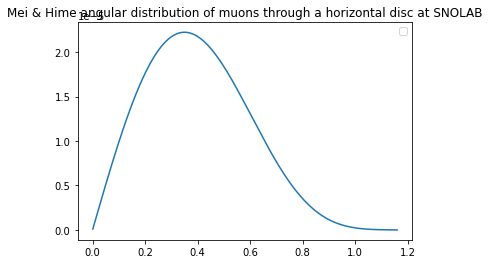

In [6]:
#Muon parameters/angular distribution

mwe_depth = 6010.0 #SNOlab
lambdaa = 825.0 #at 6000 mwe

lowlim = 1e-3
uplim = 1.16 #1 in 100,000 chance a muon will come in at steeper angle than this.
npoints = 100000
thetarad=np.linspace(lowlim, uplim, npoints)

MeiHime= np.cos(thetarad)*np.sin(thetarad)*( (8.60*1e-6)*np.exp(-(mwe_depth/1000)/(0.45*np.cos(thetarad)))+ (0.44*1e-6)*np.exp(-(mwe_depth/1000.0)/(0.87*np.cos(thetarad))) )/np.cos(thetarad)
MeiHime = MeiHime /np.sqrt(MeiHime.sum()**2.0)

plt.plot(thetarad, MeiHime)
plt.title('Mei & Hime angular distribution of muons through a horizontal disc at SNOLAB')
plt.legend()


# And now we dance...

Set up the simulation...

In [7]:
#Geometry stuff
GenDiscRad = 3200.0 #generation disc radius
GenDiscHeight = 2300.0 #generation disc height

ODradius = 655.0 #Water tank radius
ODheight = 1402.0 #water tank height (centered at zero)
OCradius = 223.0 #outer spherical cryostat radius

#The above numbers are the same as those in the other notebook

#For now, select photon energy angle etc... here.
thetaRel = 0.733 #radians, approx Cherenkov angle in optical (~0.5 degree precision)
frequency = 6.25e14

#Define custom data type here for particles
ptcl = np.dtype({'names':['x', 'y', 'z', 'px', 'py', 'pz', 'tracklength'], 
                 'formats':[np.double, np.double, np.double, np.double, np.double, np.double, np.double]})

In [8]:
#First three functions are for muons coming from outside the water
def calc_intersect_disc_external(particle, height, radius):
    t = (height - particle['z'])/particle['pz'] #z_pos + p_z*t = height
    x_new = particle['x']+particle['px']*t 
    y_new = particle['y']+particle['py']*t
    if( (x_new*x_new + y_new*y_new < radius*radius) and t>=0.):
        return np.array([x_new, y_new, particle['z']+particle['pz']*t]) #intersection point
    else:
        return False



def calc_intersect_wall_external(particle): #cylinder walls
    
    #a = mom[0]*mom[0] + mom[1]*mom[1]
    #b = 2.0*(pos[0]*mom[0]+pos[1]*mom[1])
    #c = pos[0]*pos[0] + pos[1]*pos[1] - ODradius*ODradius
    a = particle['px']*particle['px'] + particle['py']*particle['py']
    b = 2.0*(particle['x']*particle['px']+particle['y']*particle['py'])
    c = particle['x']*particle['x'] + particle['y']*particle['y']- ODradius*ODradius
    discriminant = b*b - 4.0*a*c
    
    if (discriminant<0): #doesn't intersect cylinder walls
        return False
  
    #Solve quadratic equation for t+-, if these yield intersections inside z range, keep
    t_pl = (-b + np.sqrt(discriminant))/(2.0*a)
    t_min = (-b - np.sqrt(discriminant))/(2.0*a)
    
    if(t_min<=0 and t_pl <=0):
        return False
    
    if (-ODheight/2.0<particle['z']<ODheight/2.0): #particle inside OD, take positive solution
        if(t_min>=0): #forward in time always
            x_new = particle['x']+particle['px']*t_min 
            y_new = particle['y']+particle['py']*t_min
            z_new = particle['z']+particle['pz']*t_min
            return np.array([x_new, y_new, z_new])
        elif(t_pl>0): #unnecessary but safe
            x_new = particle['x']+particle['px']*t_pl 
            y_new = particle['y']+particle['py']*t_pl
            z_new = particle['z']+particle['pz']*t_pl
            return np.array([x_new, y_new, z_new])
        else:
            return False
    
    #Cases for outside OD.
    z_new_min = particle['z']+t_min*particle['pz']
    z_new_pl = particle['z']+t_pl*particle['pz']
        
    if (t_min>=0 and t_pl>=0): # forward in time
        if((-ODheight/2.0<z_new_min<ODheight/2.0) and (-ODheight/2.0<z_new_pl<ODheight/2.0)):
            x_new = particle['x']+particle['px']*t_min
            y_new = particle['y']+particle['py']*t_min
            z_new = particle['z']+particle['pz']*t_min
            entry = np.array([x_new, y_new, z_new])
            particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]

            x_new = particle['x']+particle['px']*t_pl
            y_new = particle['y']+particle['py']*t_pl
            z_new = particle['z']+particle['pz']*t_pl
            exit = np.array([x_new, y_new, z_new])
            #particle['tracklength']=np.sqrt(np.dot(entry-exit))
            return entry, exit
        
    if(t_min>=0 and (-ODheight/2.0<z_new_min<ODheight/2.0)):
        x_new = particle['x']+particle['px']*t_min 
        y_new = particle['y']+particle['py']*t_min
        return np.array([x_new, y_new, z_new_min])
    if(t_pl>=0 and (-ODheight/2.0<z_new_pl<ODheight/2.0)): #forward in time
        x_new = particle['x']+particle['px']*t_pl 
        y_new = particle['y']+particle['py']*t_pl
        return np.array([x_new, y_new, z_new_pl])

    return False
    
def calc_intersect_OD_external(particle): #Make use of quadratic equations and be more efficient
    
    
    
    entry_set, exit_set = False, False
    
    outside_start = particle['z']>ODheight/2. #particle is above OD
    
    if(outside_start == False): #photon etc...created inside OD.
        if particle['pz']<0:
            floor_intersect = calc_intersect_disc_external(particle, -ODheight/2., ODradius)
        if particle['pz']>0:
            roof_intersect = calc_intersect_disc_external(particle, ODheight/2., ODradius)
        if(type(floor_intersect) != bool):
            return floor_intersect
        if(type(roof_intersect) != bool):
            return roof_intersect
        else: #photon hits wall somewhere
            return calc_intersect_wall_external(particle)
                

    if(outside_start):#check roof/floor first as these are fast
        #print("1")

        roof_intersect = calc_intersect_disc_external(particle, ODheight/2., ODradius)
        floor_intersect = calc_intersect_disc_external(particle, -ODheight/2., ODradius)
        
        if((particle['x']*particle['x'] + particle['y']*particle['y'] - ODradius*ODradius)<=0 and type(roof_intersect)==bool): #within radius upon start
            #print("2")
            return False #Can't intersect cylinder if misses roof in this case 
        
        elif(type(roof_intersect)!=bool):#hits roof
            entry = roof_intersect
            particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]
            entry_set = True
            #print("roof")
            if(type(floor_intersect) != bool): #entered roof, exitted floor
                #print("roof and floor")
                particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]
                return entry, floor_intersect #we are done! Lucky.
            else:#entered roof, exits wall
                #print("roof and wall")
                particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]
                exit = calc_intersect_wall_external(particle)
                #particle['tracklength']=np.sqrt(np.dot(entry-exit))
                return entry, exit
                       
        elif(type(floor_intersect) != bool and type(roof_intersect)==bool): #didn't enter roof, but did exit floor
            exit = floor_intersect
            exit_set = True
            #print("wall and floor")
            #print(calc_intersect_wall(pos,mom), exit)
            if(type(calc_intersect_wall_external(particle)) == bool):
                return False
            #Now there's only one option, it entered through the walls
            entry = calc_intersect_wall_external(particle)
            particle['x'], particle['y'], particle['z'] = entry[0], entry[1], entry[2]
            #particle['tracklength']=np.sqrt(np.dot(entry-exit))

            return entry, exit
        else:#Only other option, it entered and exitted via the walls or missed the entire thing
            #print("7")
            #print(calc_intersect_wall(pos, mom))
            return calc_intersect_wall_external(particle)
        

        
#These functions are jitted because we know there is only one positive time solution (particle is created in water)
@njit        
def calc_intersect_OD_photon(particle): #Make use of quadratic equations and be more efficient
    
    roof_intersect = calc_intersect_disc_photon(particle, ODheight/2., ODradius)
    #print("roof: ", roof_intersect)
    floor_intersect = calc_intersect_disc_photon(particle, -ODheight/2., ODradius)
    #print("floor: ", floor_intersect)
    if(roof_intersect.any() != 0.0):#hits roof
        #print("roof")
        hit = roof_intersect
        particle['x'], particle['y'], particle['z'] = hit[0], hit[1], hit[2]
        return hit
    elif(floor_intersect.any() != 0.0): #entered roof, exitted floor
        #print("floor")
        hit = floor_intersect
        particle['x'], particle['y'], particle['z'] = hit[0], hit[1], hit[2]
        return hit
    else:#entered roof, exits wall
        #print("wall")
        hit = calc_intersect_wall_photon(particle)
        particle['x'], particle['y'], particle['z'] = hit[0], hit[1], hit[2]
        #particle['tracklength']=np.sqrt(np.dot(entry-exit))
        return hit

        
#For photons we know they are created inside the OD so... JIT it!
@njit
def calc_intersect_disc_photon(particle, height, radius):
    t = (height - particle['z'])/particle['pz'] #z_pos + p_z*t = height
    x_new = particle['x']+particle['px']*t 
    y_new = particle['y']+particle['py']*t
    if( (x_new*x_new + y_new*y_new < radius*radius) and t>=0.):
        return np.array([x_new, y_new, particle['z']+particle['pz']*t]) #intersection point
    else:
        return np.zeros(3)
    
@njit
def calc_intersect_wall_photon(particle): #cylinder walls
    a = particle['px']*particle['px'] + particle['py']*particle['py']
    b = 2.0*(particle['x']*particle['px']+particle['y']*particle['py'])
    c = particle['x']*particle['x'] + particle['y']*particle['y']- ODradius*ODradius
    discriminant = b*b - 4.0*a*c
    
    if (discriminant<0): #doesn't intersect cylinder walls
        return np.zeros(3)
  
    #Solve quadratic equation for t+-, if these yield intersections inside z range, keep
    t_pl = (-b + np.sqrt(discriminant))/(2.0*a)
    t_min = (-b - np.sqrt(discriminant))/(2.0*a)
    
    if(t_min<=0 and t_pl <=0):
        return np.zeros(3)
    
    if (-ODheight/2.0<particle['z']<ODheight/2.0): #particle inside OD, take positive solution
        if(t_min>=0): #forward in time always
            x_new = particle['x']+particle['px']*t_min 
            y_new = particle['y']+particle['py']*t_min
            z_new = particle['z']+particle['pz']*t_min
            return np.array([x_new, y_new, z_new])
        if(t_pl>0): #unnecessary but safe
            x_new = particle['x']+particle['px']*t_pl 
            y_new = particle['y']+particle['py']*t_pl
            z_new = particle['z']+particle['pz']*t_pl
            return np.array([x_new, y_new, z_new])
        else:
            return np.zeros(3)

In [18]:
'''
Here we have the functions that actually create the particles
MakeMuon gives us a muon with the proper angles etc... 

MakeCherenkovPhoton takes in a position and momentum of a high energy muon 
and then creates a photon with the correct angles
'''

#This samples from a distribution based on arbitrary shape, e.g. muon angular flux by Mei & Hime
@njit
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

@njit
def MakeMuons(numMuons):
    muons = np.zeros(numMuons, dtype=ptcl)
    
    for i in prange(muons.shape[0]):
        #theta = np.random.choice(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)),p=MeiHime)
        theta=rand_choice_nb(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)), MeiHime)
        #theta = np.random.choice(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)))
        phi = np.random.sample()*np.pi*2.0 #Random number in [0,2pi]

        r = np.sqrt(np.random.sample())*GenDiscRad #radius to generate particle on disc
        muons[i]['x']=np.sin(phi)*r#x position set by sin
        muons[i]['y']=np.cos(phi)*r #y position
        muons[i]['z'] = GenDiscHeight
        #print(self.position)
        momentum = np.array([-muons[i]['x'], -muons[i]['y'], 0.],dtype=np.double)
        momentum = momentum/np.sqrt(np.dot(momentum,momentum)) #normalize

        #If above OD directly
        if((muons[i]['x']*muons[i]['x'] + muons[i]['y']*muons[i]['y'])<=ODradius*ODradius):
            phi_smear= np.random.sample()*2.0*np.pi
        else:
            #smear randomly (but face OD in XY plane)
            phi_smear = np.arctan(ODradius/np.sqrt(muons[i]['x']*muons[i]['x'] + muons[i]['y']*muons[i]['y']))*(2.0*np.random.sample()-1.0)

        c, s = np.cos(phi_smear), np.sin(phi_smear)
        ux, uy, uz = [0.,0.,1.0] #Need to rotate around z axis 
        #Rotation matrix, note is it counterclockwise if axis is facing you
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum) #rotated momentum
        #rotate it downwards now by the amount theta (following muon angular distribution)
        #i.e. about the axis p cross z (axis out of page/into page)
        ux, uy, uz = np.cross([0,0,1], momentum)
        rotateDown = np.pi/2.0 - theta
        c, s = np.cos(rotateDown), np.sin(rotateDown)
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)

        muons[i]['px'], muons[i]['py'],muons[i]['pz'] = momentum[0], momentum[1], momentum[2]
    return muons



numEvents = 60000
#%timeit MakeMuons(numEvents)

muons=MakeMuons(numEvents)

#print(muons)
i=0
j=0
for mu in muons:
    if type(calc_intersect_OD_external(mu))!=bool:
        i+=1
    if mu['z']!=2300.: #Only keep ones that enter the water tank, change their position to where they enter
        j+=1
print(i,j)
mask = muons['z']!=2300. #These are the muons that actually make it into the water (don't miss the tank) 
# ~1/3 of them
    


21259 21259


We get a factor of ~2 improvement in speed here by jitting the function.

In [19]:
#Need to write new function without python, which will propagate the light in the water
#It will take in the array of muons which enter the OD, generate photons according to Cherenkov 
#physics all along their tracks
#Return a lightmap of where the photons intersected the wall/floor/roof

@njit
def propagateChere(parentPtcl):
    
    parentMomentum = np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])
    parentEntryPosition = np.array([parentPtcl['x'], parentPtcl['y'], parentPtcl['z']])
    
    parentEndPosition = calc_intersect_OD_photon(parentPtcl)
    
    dx, dy, dz = parentEndPosition[0] - parentEntryPosition[0], parentEndPosition[1] - parentEntryPosition[1], parentEndPosition[2] - parentEntryPosition[2]
    
    #print(parentEntryPosition)
    #print(parentEndPosition)
    trackLength = np.sqrt(dx*dx+dy*dy+dz*dz)
    
    #Note now the muon has moved to it's final position
    
    photonsPerCm=100 #this is set by the physics in the Frank-Tamm formula
    numPhotons = int(trackLength*photonsPerCm)
    
    photons = np.zeros(numPhotons, dtype=ptcl) #output array of photons, can't be parallelized with njit :(
    #photons=np.zeros(numPhotons)
    #assert 1==0
    for i in prange(numPhotons):
        
        numStepsAway = np.random.rand()*trackLength #pick a random point on the track
        
        #photon position
        photons[i]['x']=parentEntryPosition[0]+numStepsAway*parentPtcl['px'] 
        photons[i]['y']=  parentEntryPosition[1]+numStepsAway*parentPtcl['py']
        photons[i]['z'] = parentEntryPosition[2]+numStepsAway*parentPtcl['pz']

        momentum=np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])

        #First, rotate relative to z axis by Cherenkov angle
        c, s = np.cos(thetaRel), np.sin(thetaRel) #cos and sine
        ux, uy, uz = np.cross(parentMomentum, [0.,0.,1.0]) #Need to rotate around axis out of page/into page
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)
        #momentum= np.dot(R, momentum)

        #Now rotate random amount of phi about axis of parent trajectory
        phi=np.random.sample()*np.pi*2.0
        c, s = np.cos(phi), np.sin(phi) #cos and sine
        ux, uy, uz = parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)
        
        #Photon momentum set sow now leave track in a cherenkov cone 
        photons[i]['px'], photons[i]['py'], photons[i]['pz'] = momentum[0], momentum[1], momentum[2]
        
        #Deal with the intersection/photon hit here
        calc_intersect_OD_photon(photons[i])
        i+=1
        
    #Return the photon hit positions
    return photons

Number of photons in this event: 137611


<IPython.core.display.Javascript object>


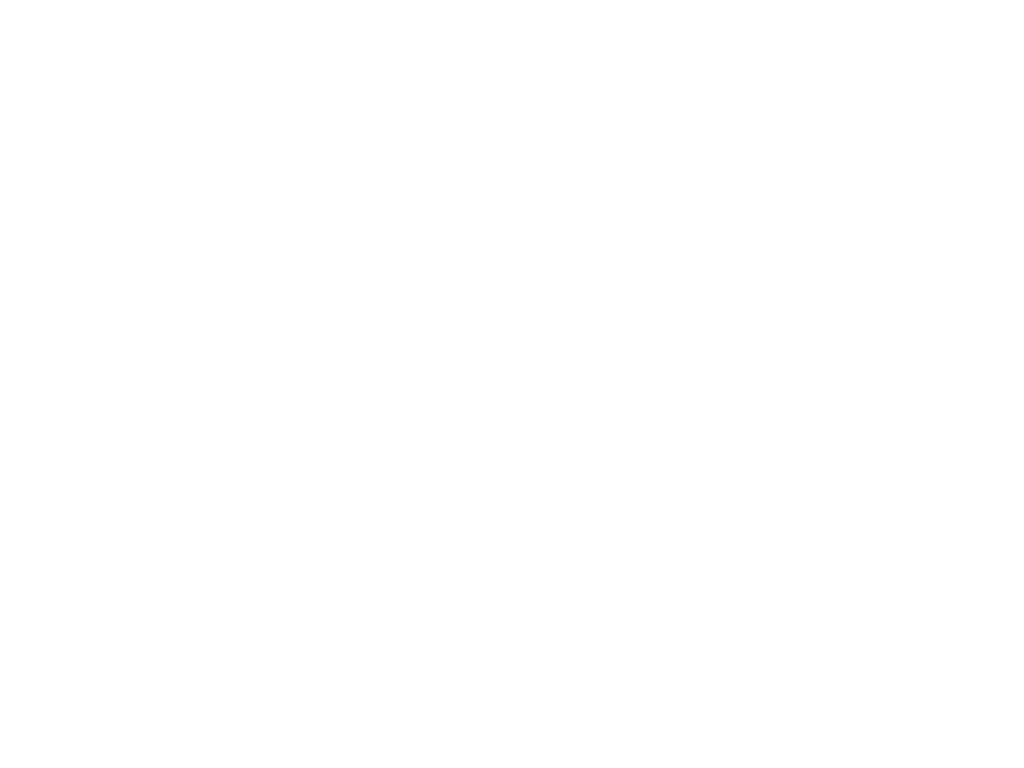

AttributeError: 'AxesSubplot' object has no property 'axisbg'

In [20]:
#Iterate through those muons that make it into the water tank. 
#Produce Cherenkov light distributions
muonsInWater = muons[mask] #only ones which traverse in the water
eventNumber = 2 #example event
photons1 = propagateChere(muonsInWater[eventNumber])
#%timeit photons1 = propagateChere(muonsInWater[eventNumber])
print("Number of photons in this event: "+repr(photons1.size))
track=[]
scale = 500

#for i in range(1000):
#    track.append(np.array([muonsInWater[eventNumber]['x']-scale*i*muonsInWater[eventNumber]['px'], muonsInWater[eventNumber]['y']-scale*i*muonsInWater[eventNumber]['py'], muonsInWater[eventNumber]['z']-scale*i*muonsInWater[eventNumber]['pz']]))

    
#print(track)

from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
ax.scatter(photons1['x'],photons1['y'],photons1['z'], label='Photons', alpha=0.1, s=0.5, lw=0)
xarr = muonsInWater[eventNumber]['x']-muonsInWater[eventNumber]['px']*scale
yarr = muonsInWater[eventNumber]['y']-muonsInWater[eventNumber]['py']*scale
zarr = muonsInWater[eventNumber]['z']-muonsInWater[eventNumber]['pz']*scale
xdir=muonsInWater[eventNumber]['px']*scale
ydir=muonsInWater[eventNumber]['py']*scale
zdir=muonsInWater[eventNumber]['pz']*scale
ax.quiver(xarr,yarr,zarr,xdir,ydir,zdir,color='orange',arrow_length_ratio=0.1, label='Muon track')
#ax.scatter(track[:][0],track[:][1],track[:][2], label='Muon Track', alpha=0.9, s=0.5)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
plt.legend()
plt.show()
#plt.ion()
#plt.savefig("ExampleLightMapOneEvent.pdf")

Kinda cool that just by jitting the functions (not parallelized) we get factors of ~10X improvement in speed.

In [21]:
#Now let's stack many muons!
events = []
for i in range(muonsInWater.size):
    if i%10 ==0:
        print("Event number: "+repr(i))
    events.append(propagateChere(muonsInWater[i]))


Event number: 0
Event number: 10
Event number: 20
Event number: 30
Event number: 40
Event number: 50
Event number: 60
Event number: 70
Event number: 80
Event number: 90
Event number: 100
Event number: 110
Event number: 120
Event number: 130
Event number: 140
Event number: 150
Event number: 160
Event number: 170
Event number: 180
Event number: 190
Event number: 200
Event number: 210
Event number: 220
Event number: 230
Event number: 240
Event number: 250
Event number: 260
Event number: 270
Event number: 280
Event number: 290
Event number: 300
Event number: 310
Event number: 320
Event number: 330
Event number: 340
Event number: 350
Event number: 360
Event number: 370
Event number: 380
Event number: 390
Event number: 400
Event number: 410
Event number: 420
Event number: 430
Event number: 440
Event number: 450
Event number: 460
Event number: 470
Event number: 480
Event number: 490
Event number: 500
Event number: 510
Event number: 520
Event number: 530
Event number: 540
Event number: 550
Eve

Event number: 4380
Event number: 4390
Event number: 4400
Event number: 4410
Event number: 4420
Event number: 4430
Event number: 4440
Event number: 4450
Event number: 4460
Event number: 4470
Event number: 4480
Event number: 4490
Event number: 4500
Event number: 4510
Event number: 4520
Event number: 4530
Event number: 4540
Event number: 4550
Event number: 4560
Event number: 4570
Event number: 4580
Event number: 4590
Event number: 4600
Event number: 4610
Event number: 4620
Event number: 4630
Event number: 4640
Event number: 4650
Event number: 4660
Event number: 4670
Event number: 4680
Event number: 4690
Event number: 4700
Event number: 4710
Event number: 4720
Event number: 4730
Event number: 4740
Event number: 4750
Event number: 4760
Event number: 4770
Event number: 4780
Event number: 4790
Event number: 4800
Event number: 4810
Event number: 4820
Event number: 4830
Event number: 4840
Event number: 4850
Event number: 4860
Event number: 4870
Event number: 4880
Event number: 4890
Event number

Event number: 8700
Event number: 8710
Event number: 8720
Event number: 8730
Event number: 8740
Event number: 8750
Event number: 8760
Event number: 8770
Event number: 8780
Event number: 8790
Event number: 8800
Event number: 8810
Event number: 8820
Event number: 8830
Event number: 8840
Event number: 8850
Event number: 8860
Event number: 8870
Event number: 8880
Event number: 8890
Event number: 8900
Event number: 8910
Event number: 8920
Event number: 8930
Event number: 8940
Event number: 8950
Event number: 8960
Event number: 8970
Event number: 8980
Event number: 8990
Event number: 9000
Event number: 9010
Event number: 9020
Event number: 9030
Event number: 9040
Event number: 9050
Event number: 9060
Event number: 9070
Event number: 9080
Event number: 9090
Event number: 9100
Event number: 9110
Event number: 9120
Event number: 9130
Event number: 9140
Event number: 9150
Event number: 9160
Event number: 9170
Event number: 9180
Event number: 9190
Event number: 9200
Event number: 9210
Event number

Event number: 12880
Event number: 12890
Event number: 12900
Event number: 12910
Event number: 12920
Event number: 12930
Event number: 12940
Event number: 12950
Event number: 12960
Event number: 12970
Event number: 12980
Event number: 12990
Event number: 13000
Event number: 13010
Event number: 13020
Event number: 13030
Event number: 13040
Event number: 13050
Event number: 13060
Event number: 13070
Event number: 13080
Event number: 13090
Event number: 13100
Event number: 13110
Event number: 13120
Event number: 13130
Event number: 13140
Event number: 13150
Event number: 13160
Event number: 13170
Event number: 13180
Event number: 13190
Event number: 13200
Event number: 13210
Event number: 13220
Event number: 13230
Event number: 13240
Event number: 13250
Event number: 13260
Event number: 13270
Event number: 13280
Event number: 13290
Event number: 13300
Event number: 13310
Event number: 13320
Event number: 13330
Event number: 13340
Event number: 13350
Event number: 13360
Event number: 13370


Event number: 16980
Event number: 16990
Event number: 17000
Event number: 17010
Event number: 17020
Event number: 17030
Event number: 17040
Event number: 17050
Event number: 17060
Event number: 17070
Event number: 17080
Event number: 17090
Event number: 17100
Event number: 17110
Event number: 17120
Event number: 17130
Event number: 17140
Event number: 17150
Event number: 17160
Event number: 17170
Event number: 17180
Event number: 17190
Event number: 17200
Event number: 17210
Event number: 17220
Event number: 17230
Event number: 17240
Event number: 17250
Event number: 17260
Event number: 17270
Event number: 17280
Event number: 17290
Event number: 17300
Event number: 17310
Event number: 17320
Event number: 17330
Event number: 17340
Event number: 17350
Event number: 17360
Event number: 17370
Event number: 17380
Event number: 17390
Event number: 17400
Event number: 17410
Event number: 17420
Event number: 17430
Event number: 17440
Event number: 17450
Event number: 17460
Event number: 17470


Event number: 21080
Event number: 21090
Event number: 21100
Event number: 21110
Event number: 21120
Event number: 21130
Event number: 21140
Event number: 21150
Event number: 21160
Event number: 21170
Event number: 21180
Event number: 21190
Event number: 21200
Event number: 21210
Event number: 21220
Event number: 21230
Event number: 21240
Event number: 21250


In [ ]:
#print(events[4]['x'])
x=[]
y=[]
z=[]
for ev in events:
    x.extend(ev['x'])
    y.extend(ev['y'])
    z.extend(ev['z'])

#Bin sizes of 8" or 20.3 cm are typical dimensions (diameter) of PMT used in these experiments
plt.hist2d(x,y, bins = [np.arange(-654, 654, 20.3), np.arange(-654, 654, 20.3)])
plt.title('Photon hit distribution in the X-Y plane')
plt.colorbar()
plt.show()
#plt.savefig("photonHistInXYPlane.pdf")

<IPython.core.display.Javascript object>


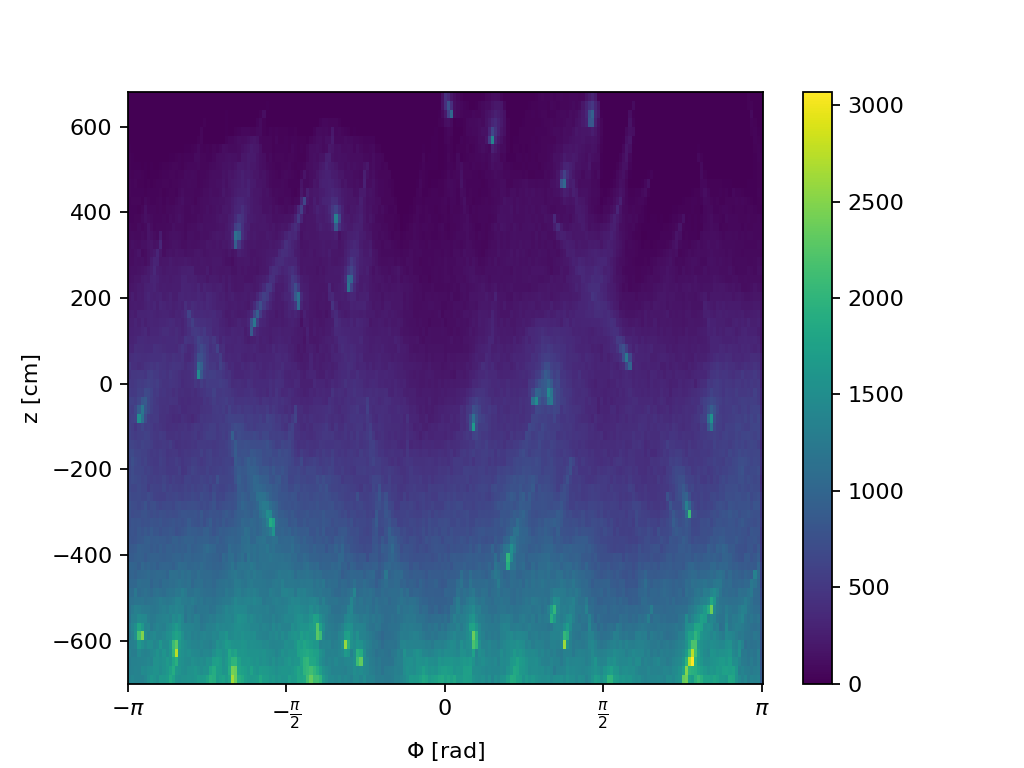

In [28]:

#plt.hist2d(np.arctan(np.asarray(x)/np.asarray(y)),z, bins = [np.arange(-np.pi, np.pi, 0.031), np.arange(-700, 700, 20.3)])
plt.hist2d(np.arctan2(y, x), z,
           bins=[np.arange(-np.pi, np.pi + 0.031, 0.031), np.arange(-700, 700, 20.3)])

#plt.title('Photon hit distribution in the Phi-Z plane')
plt.colorbar()
plt.xlabel(r'$\Phi$ [rad]')
plt.ylabel(r'z [cm]')
x_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
x_tick_labels = [r"$-\pi$", r"$-\frac{\pi}{2}$", "0", r"$\frac{\pi}{2}$", r"$\pi$"]
plt.xticks(x_ticks, x_tick_labels)
# plt.show()
# plt.savefig("photonHistInPhiZPlane.pdf", dpi=600)
# plt.savefig("photonHistInPhiZPlane.png", dpi=600)


Okay so from the last two figures we see that the majority of the photons in fact land on the floor of your water tank and not the walls. If you're trying to optimize photo coverage you would place PMTs/photosensors on the bottom floor for highest likelihood of detection. As the muon approaches a surface, it 'fills in' it's Cherenkov cone before passing through the wall. You can even make out tracks by eye already by searching for the bright patches and the way tey smear!

Unfortunately, this is where the story ends for the class. I do not have time to finish this project fully before the exam. 

# Conclusions and Review: 
- We could further speed this up by parallelizing the photon tracking/utilizing the GPU + cuda kernels in Numba ( I tried this but it got complicated fast!)
    - Nevertheless, our implementation qualitatively matches what you expect from a full GEANT4 simulation, but runs ~100X faster. We are missing ionization light, brehmstrallung, and electron scattering which can cause further Cherenkov not in line with the primary muon track. Although, this simple simulation shows that these effects are rather small compared to the primary Cherenkov light from the muon itself! Cool.
- Our cryostat/inner detector is no included, but it should be there. This would produce interesting showing/reflection effects. Also, what would the photon distribution on this object look like? 
- We need to build a better data model!
    - the point was to see if we could tell muons that pass close to the inner detector from those that don't, this 'impact parameter' can be put into the particle data type.
    - Eventually, we could 'turn off' some pixels (reduce the number of cells in the histograms) and/or see which ones matter most and training a neural net on this data. This would tell us where to place PMTs/sensors in order to optimize either a) photocoverage, b) tracking c) some combination of (a) & (b)
    - Right now, the entry/exit information is lost when propagating the light in the tank.
    
    
All in all, it seems like a very promising start! More effort should be placed on:
- Putting in a cryostat, shadowing and reflections.
- Fixing a proper data model to investigate the data event-by-event
- Training a neural net to tell muons which pass close to center from those which don't. 
- GPU accelerated photon propagation

Check out the attached project description PDF file for some more discussion.

Cheers!

Soud Al Kharusi, December 2019

In [25]:
'''
#What do the light maps look like when stacked on top of eachother?
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.scatter(x, y, z, c=z, cmap='viridis')
for i in range(muonsInWater.size):
    ax.scatter(events[i]['x'], events[i]['y'], events[i]['z'], lw=0, s=0.5,alpha=0.1)
# Add a color bar which maps values to colors.
#fig.colorbar(shrink=0.5, aspect=5)
plt.show()
#plt.savefig("ExampleLightMapManyEvents.pdf")
'''

'\n#What do the light maps look like when stacked on top of eachother?\nfrom mpl_toolkits.mplot3d import Axes3D\n\nfig = plt.figure()\nax = fig.gca(projection=\'3d\')\n#ax.scatter(x, y, z, c=z, cmap=\'viridis\')\nfor i in range(muonsInWater.size):\n    ax.scatter(events[i][\'x\'], events[i][\'y\'], events[i][\'z\'], lw=0, s=0.5,alpha=0.1)\n# Add a color bar which maps values to colors.\n#fig.colorbar(shrink=0.5, aspect=5)\nplt.show()\n#plt.savefig("ExampleLightMapManyEvents.pdf")\n'